# Yandex.Afisha business metrics analysis

You've done beautifully in the Practicum course, and you've been offered an internship in the analytical department at Yandex.Afisha. Your first task is to help optimize marketing expenses.
You have:
* Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
* Dump file with all orders for the period
* Marketing expenses statistics

You are going to study:
* How people use the product
* When they start to buy
* How much money each customer brings
* When they pay off

## Step 1. Download the data and prepare it for analysis

In [2]:
#load libraries

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import warnings; warnings.simplefilter('ignore')


from functools import reduce
from math import factorial
from scipy import stats as st
from statistics import mean 
from IPython.display import display


pd.set_option('display.max_columns', 500)

In [3]:
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')


First step is to check file sizes and see if I can make them lighter by converting datatypes.

In [4]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 79.3 MB


In [5]:
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
205827,desktop,2018-05-18 10:55:00,5,2018-05-18 09:16:00,7654636749667288880
51568,desktop,2018-05-14 22:38:00,3,2018-05-14 22:35:00,15033293459920254393
79943,desktop,2017-06-02 12:48:00,3,2017-06-02 12:37:00,7225125819688884766
351306,desktop,2018-05-10 17:23:00,9,2018-05-10 17:22:00,4623183830589441118
137411,desktop,2018-05-24 22:53:00,5,2018-05-24 22:46:00,13031693977804575955


In [6]:
visits.Device.value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

In [7]:
visits['Device'] = visits['Device'].astype('category')

In [8]:
visits['End Ts']= pd.to_datetime(visits['End Ts'], format="%Y-%m-%d %H:%M:%S")
visits['Start Ts']= pd.to_datetime(visits['Start Ts'], format="%Y-%m-%d %H:%M:%S")

In [9]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null category
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


Much better! Now let's rename the columns.

In [10]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null category
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


Let's have a bit closer look at the data.

In [11]:
visits.describe(include='all')

,device,end_ts,source_id,start_ts,uid
count,359400,359400,359400.000000,359400,3.594000e+05
unique,2,224760,NaN,224303,NaN
top,desktop,2017-11-24 16:51:00,NaN,2017-11-24 16:06:00,NaN
freq,262567,23,NaN,19,NaN
first,NaN,2017-06-01 00:02:00,NaN,2017-06-01 00:01:00,NaN
last,NaN,2018-06-01 01:26:00,NaN,2018-05-31 23:59:00,NaN
mean,NaN,NaN,3.750515,NaN,9.202557e+18
std,NaN,NaN,1.917116,NaN,5.298433e+18
min,NaN,NaN,1.000000,NaN,1.186350e+13
25%,NaN,NaN,3.000000,NaN,4.613407e+18


This data doesn't seem to have any missing values or obvious nonsence. Looks pretty useful for closer analysis.

Now I repeat it with orders and costs tables.

In [12]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 4.4 MB


In [13]:
orders.sample(5)

,Buy Ts,Revenue,Uid
37009,2018-02-26 11:20:00,2.44,233786961902768308
2254,2017-06-29 16:48:00,1.83,3350212363338545294
47157,2018-05-13 17:53:00,5.50,12771443857325540846
33426,2018-02-07 15:47:00,1.77,2855826466565515337
16084,2017-11-04 13:42:00,20.78,11920452646463905188


In [14]:
orders['Buy Ts']= pd.to_datetime(orders['Buy Ts'], format="%Y-%m-%d %H:%M:%S")

In [15]:
orders.columns = ['buy_ts','revenue','uid']
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [16]:
orders.describe(include='all')

,buy_ts,revenue,uid
count,50415,50415.000000,5.041500e+04
unique,45991,NaN,NaN
top,2018-05-31 10:13:00,NaN,NaN
freq,9,NaN,NaN
first,2017-06-01 00:10:00,NaN,NaN
last,2018-06-01 00:02:00,NaN,NaN
mean,NaN,4.999647,9.098161e+18
std,NaN,21.818359,5.285742e+18
min,NaN,0.000000,3.135781e+14
25%,NaN,1.220000,4.533567e+18


This data doesn't seem to have any missing values or obvious nonsence. Looks pretty useful for closer analysis.

In [17]:
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.2 KB


In [18]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [19]:
#transform dt column to datetime format
costs['dt']= pd.to_datetime(costs['dt'], format="%Y-%m-%d")

In [20]:
costs.describe(include='all')

,source_id,dt,costs
count,2542.000000,2542,2542.000000
unique,NaN,364,NaN
top,NaN,2018-03-03 00:00:00,NaN
freq,NaN,7,NaN
first,NaN,2017-06-01 00:00:00,NaN
last,NaN,2018-05-31 00:00:00,NaN
mean,4.857199,NaN,129.477427
std,3.181581,NaN,156.296628
min,1.000000,NaN,0.540000
25%,2.000000,NaN,21.945000


This data is already alright. I don't see any missing values or anything like that.

## Step 2. Make reports and calculate metrics.

### Product

#### How many people use it every day, week, and month?


In [21]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [22]:
visits['visit_date'] = visits.start_ts.dt.date.astype('datetime64[D]')
visits['visit_year'] = visits.visit_date.astype('datetime64[Y]')
visits['visit_month'] = visits.visit_date.astype('datetime64[M]')
visits['visit_week'] = visits.visit_date.astype('datetime64[W]')

In [23]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_date,visit_year,visit_month,visit_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-01-01,2017-12-01,2017-12-14
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-01-01,2018-02-01,2018-02-15
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-01-01,2017-07-01,2017-06-29
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-01-01,2018-05-01,2018-05-17
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-01-01,2017-12-01,2017-12-21


In [24]:
#find duration of each visit
visits['duration'] = visits.end_ts - visits.start_ts

In [25]:
#get rid of 0 seconds visits
visits = visits.query('duration > "00:00:00"')

In [26]:
dau_total = int(visits.groupby('visit_date').agg({'uid': 'nunique'}).mean())
wau_total = int(visits.groupby(['visit_year', 'visit_week']).agg({'uid': 'nunique'}).mean())
mau_total = int(visits.groupby(['visit_year', 'visit_month']).agg({'uid': 'nunique'}).mean())

print('Mean number of daily unique users:', dau_total )
print('Mean number of weekly unique users:', wau_total)
print('Mean number of monthly unique users:', mau_total )
print('Monthly sticky factor: {:.3f}'.format(dau_total / mau_total))
print('Weekly sticky factor: {:.3f}'.format(dau_total / wau_total))

Mean number of daily unique users: 817
Mean number of weekly unique users: 5063
Mean number of monthly unique users: 20955
Monthly sticky factor: 0.039
Weekly sticky factor: 0.161


Let's have a deeper look at this data and plot graphs on how the average number of users changed throughout all this time. I'll make two charts: one per week, one per month.

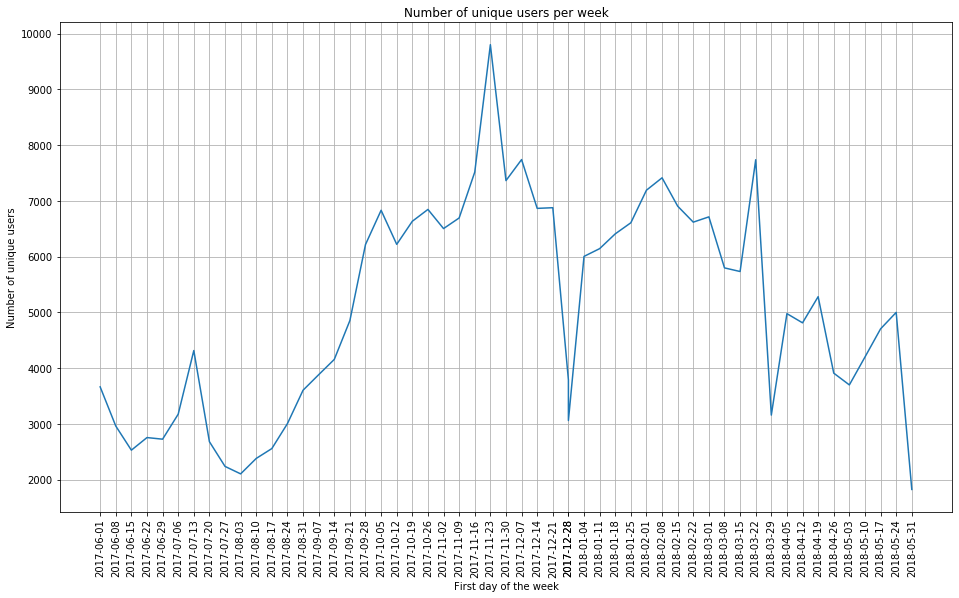

In [27]:
df = visits.groupby(['visit_year', 'visit_week']).agg({'uid': 'nunique'}).reset_index()
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(df.visit_week, df.uid)

ax.set(xlabel='First day of the week', ylabel='Number of unique users',
       title='Number of unique users per week')
ax.grid()

plt.xticks(df.visit_week, rotation=90)
plt.show();

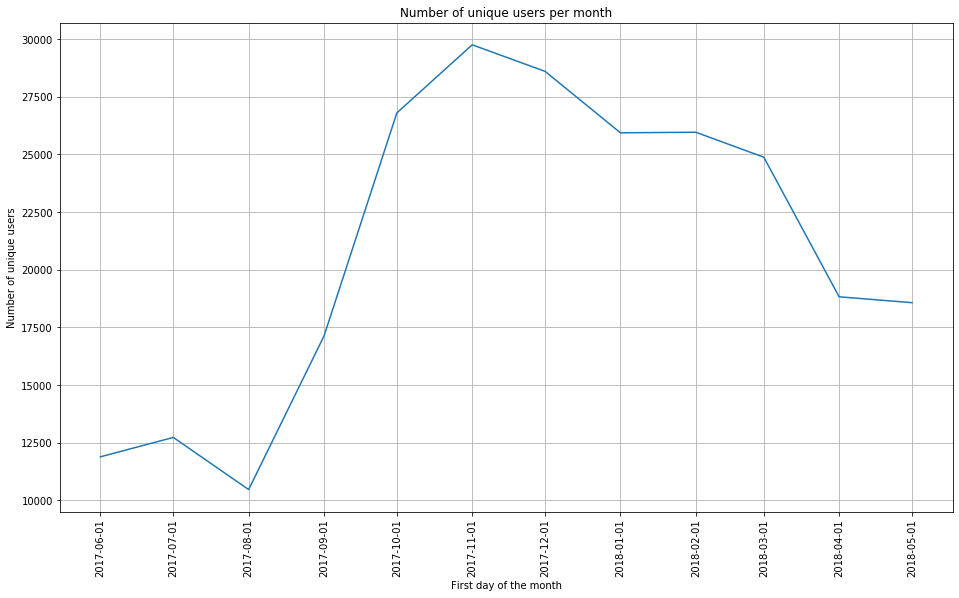

In [28]:
df = visits.groupby(['visit_year', 'visit_month']).agg({'uid': 'nunique'}).reset_index()
fig, ax = plt.subplots(figsize = (16,9))

ax.plot(df.visit_month, df.uid)
ax.set(xlabel='First day of the month', ylabel='Number of unique users',
       title='Number of unique users per month')
ax.grid()
plt.xticks(df.visit_month, rotation=90)
plt.show();

#### Conclusion
Amount of visitors have risen during autumn, but than it seems to have had some decline. It may be due to seasonal changes, or maybe something is wrong with the app, I'm going to check it later.

#### How many sessions are there per day? (One user might have more than one session.)


In [29]:
sessions_per_day = (visits.groupby(['visit_date', 'uid']) #group values by date and users
                    .agg({'start_ts':'nunique'}) #find for each user amount of sessions for each day
                    .reset_index()
                    .groupby('visit_date')[['start_ts']].sum().reset_index() #get sessions per day
)
sessions_per_day

,visit_date,start_ts
0,2017-06-01,599
1,2017-06-02,596
2,2017-06-03,429
3,2017-06-04,447
4,2017-06-05,807
...,...,...
359,2018-05-27,582
360,2018-05-28,1041
361,2018-05-29,942
362,2018-05-30,1265


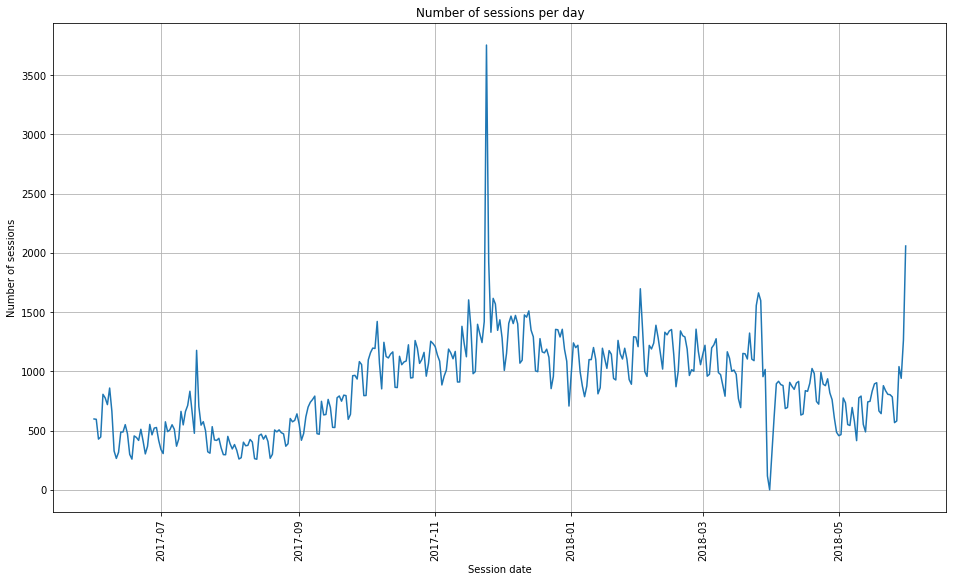

In [30]:
df = sessions_per_day
fig, ax = plt.subplots(figsize = (16,9))

ax.plot(df.visit_date, df.start_ts)
ax.set(xlabel='Session date', ylabel='Number of sessions',
       title='Number of sessions per day')
ax.grid()
plt.xticks(rotation=90)
plt.show();

In [31]:
print('Average amount of sessions per day: {:.1f}'.format(sessions_per_day.start_ts.mean()))
print('Average sessions per day per user: {:.1f}'.format(sessions_per_day.start_ts.mean() /dau_total))

Average amount of sessions per day: 889.0
Average sessions per day per user: 1.1


I see from this analysis that average amount of sessions per day has changed throughout the year. But mostly it hasn't been much more than 1 session a day per user. But also There is some strange anomaly sometime in November with very high amount of sessions, let's build boxplot to check how the data is ditrbuted.

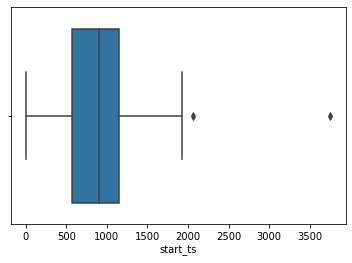

In [32]:
sns.boxplot(sessions_per_day.start_ts)

In [33]:
sessions_per_day.sort_values('start_ts',ascending=False).head()

,visit_date,start_ts
176,2017-11-24,3755
363,2018-05-31,2059
177,2017-11-25,1925
245,2018-02-01,1698
298,2018-03-26,1663


In [34]:
#check amount of unique users for this date
visits[visits['visit_date'] == '2017-11-24'].nunique()

device            2
end_ts         1068
source_id         7
start_ts       1021
uid            3090
visit_date        1
visit_year        1
visit_month       1
visit_week        1
duration        158
dtype: int64

It looks like something had happened on 24.11.2017. I'm not sure what was it. It could have been some event that caused lots of people to get to Yandex.Afisha or maybe some DDoS atack took place or something else. It would have been better to check this information with other departments.

#### Conclusion
On average there has been 889 sessions per day, amount of sessions have changed through the year, its raise looks simillar to raise of amount of unique users.

#### What is the length of each session?

As I have already calculated sessions' duration for each session, I don't need to do it now. I suppose that session duration should have somhow normal distribution or at least "normalish". Let's have a look at it.

In [35]:
#convert duration to seconds
visits['duration'] = visits.duration.dt.seconds

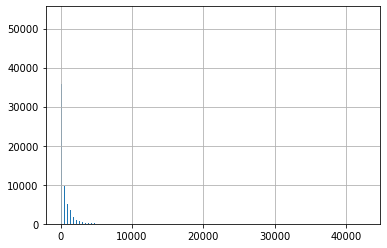

In [36]:
visits.duration.hist(bins='auto')

Not normal....

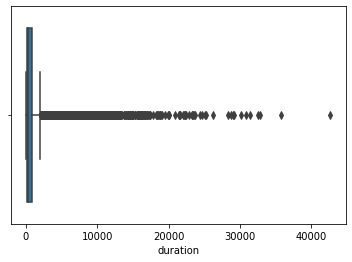

In [37]:
sns.boxplot(visits.duration)

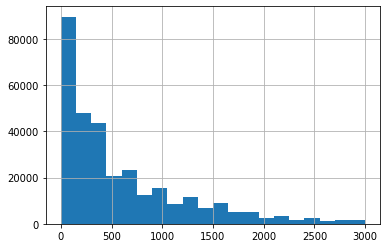

In [38]:
#let's plot it without outhlighers
visits.duration.hist(bins=20, range=(0,3000))

In [39]:
visits.duration.describe()

count    323604.000000
mean        714.169516
std        1026.349417
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       42660.000000
Name: duration, dtype: float64

So median lenth of a session is 360 seconds (6 minutes), while mean value is around 12 minutes. Let's calculate mean value for each day and then see distribution that way.

Mean value of session length is: 691.41


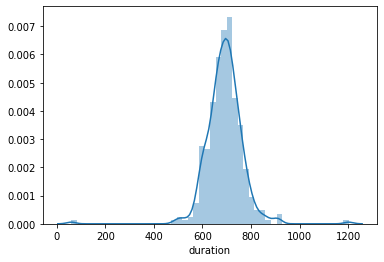

In [40]:
df=visits.groupby('visit_date')['duration'].mean()
sns.distplot(df)
print ('Mean value of session length is: {:.2f}'.format(df.mean()))

#### Conclusion
Average lenght of a session is - 11.5 minutes, while median user usually spends on Yandex.Afisha around 6 minutes.

In [46]:
visits.duration.value_counts()

0    60
dtype: int64

#### How often do users come back?

To do this I'll calculate retention rate for all users, devided by cohorts. Here I will use months as cohort parameters.

In [104]:
#Add first visit date
visits['first_visit_date'] = visits.groupby('uid')['visit_date'].transform('min')
visits

,device,end_ts,source_id,start_ts,uid,visit_date,visit_year,visit_month,visit_week,duration,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-01-01,2017-12-01,2017-12-14,1080,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-01-01,2018-02-01,2018-02-15,1680,2018-02-19
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-01-01,2018-05-01,2018-05-17,1440,2018-03-09
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-01-01,2017-09-01,2017-08-31,60,2017-09-03
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,2018-01-01,2018-01-01,2018-01-25,3360,2017-06-29
...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-01-01,2017-07-01,2017-07-27,19,2017-07-29
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018-01-01,2018-01-01,2018-01-25,19,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018-01-01,2018-03-01,2018-03-01,19,2018-03-03
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-01-01,2017-11-01,2017-11-02,19,2017-11-02


In [105]:
#add month of the first visit
visits['first_visit_month'] = visits.first_visit_date.astype('datetime64[M]')
#calculate lifetime of each cohort
visits['cohort_lifetime'] = ((visits.visit_month - visits.first_visit_month)/np.timedelta64(1,'M')).round().astype(int)
visits.cohort_lifetime.value_counts()

0     242549
1      20817
2      13145
3      10624
4       8763
5       7414
6       6003
7       4624
8       3565
9       2719
10      1939
11      1442
Name: cohort_lifetime, dtype: int64

In [106]:
#create table for cohorts
cohorts = visits.groupby(['first_visit_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.head()

,first_visit_month,cohort_lifetime,uid
0,2017-06-01,0,11885
1,2017-06-01,1,900
2,2017-06-01,2,606
3,2017-06-01,3,710
4,2017-06-01,4,777


In [107]:
cohorts['cohort_users'] = cohorts.groupby('first_visit_month')['uid'].transform('max') #add column for all users of each cohort
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users'] #calculate retention
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

In [108]:
retention_pivot = cohorts.pivot_table(values='retention', index='first_visit_month',
                                      columns='cohort_lifetime', aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06,1.0,0.075726,0.050989,0.059739,0.065377,0.067480,0.057720,0.056121,0.050989,0.049727,0.038115,0.043921
2017-07,1.0,0.054545,0.050402,0.055645,0.056660,0.046512,0.044059,0.044059,0.037886,0.027315,0.027061,NaN
2017-08,1.0,0.074452,0.060451,0.060451,0.047970,0.041459,0.036249,0.037660,0.027133,0.024745,NaN,NaN
2017-09,1.0,0.083570,0.067769,0.049322,0.038083,0.036959,0.035372,0.022876,0.022744,NaN,NaN,NaN
2017-10,1.0,0.078129,0.050811,0.037811,0.033648,0.031184,0.020775,0.019798,NaN,NaN,NaN,NaN
2017-11,1.0,0.078183,0.042733,0.037824,0.032593,0.021729,0.020602,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.054668,0.036518,0.030178,0.019453,0.017716,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.057794,0.037817,0.024352,0.019249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.056561,0.024290,0.019184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


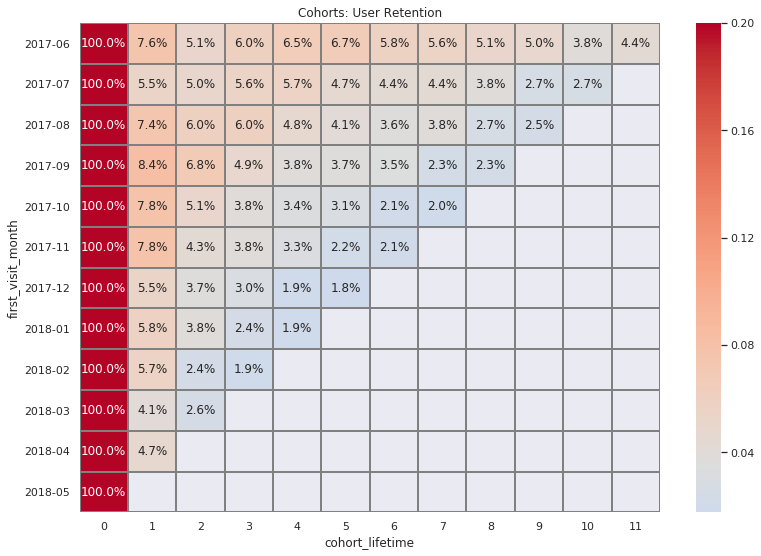

In [109]:
sns.set(style='dark')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%',cmap='coolwarm', linewidths=1, linecolor='gray',
            center=0.035, vmax=0.2);

#### Conclusion

Usually from 4 to 8 percent of users come back to Yandex.Afisha on the second month. Wee see that first cohorts have higher return rate than the newest ones. For cohorts of March and April of 2018 only around 2% of users return on the third month. We actually see fall of return rates for all cohorts in the last months, maybe there has been less notifications or something has happened to the platform. I recommend to marketing departmant to check what changes with user notifications has been made and maybe turn them around.

### Sales

#### When do people start buying?

Let's find date of first order for each user.

In [110]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [126]:
#create first orders table
user_orders = (orders
                .groupby('uid')[['buy_ts','revenue']]
                .agg({'buy_ts':'min', 'revenue':'sum'}).reset_index()
                .rename(columns={'buy_ts':'first_order','revenue':'total_revenue'})
              )
user_orders

,uid,first_order,total_revenue
0,313578113262317,2018-01-03 21:51:00,0.55
1,1575281904278712,2017-06-03 10:13:00,3.05
2,2429014661409475,2017-10-11 18:33:00,73.33
3,2464366381792757,2018-01-28 15:54:00,2.44
4,2551852515556206,2017-11-24 10:14:00,10.99
...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,3.05
36519,18445407535914413204,2017-09-22 23:55:00,0.88
36520,18445601152732270159,2018-03-26 22:54:00,4.22
36521,18446156210226471712,2018-02-18 19:34:00,9.78


Make a query for a dataframe that will only have info for first logins to Yandex Afisha.

In [127]:
first_visits = visits[visits['start_ts'] == visits.groupby('uid')['start_ts'].transform('min')]

Merge these two dataframes into one that will have all info needed for this analysis.

In [128]:
user_orders = user_orders.merge(first_visits[['uid','first_visit_date',
                                               'source_id','device']], on='uid', how='left')
user_orders

,uid,first_order,total_revenue,first_visit_date,source_id,device
0,313578113262317,2018-01-03 21:51:00,0.55,2017-09-18,2.0,desktop
1,1575281904278712,2017-06-03 10:13:00,3.05,2017-06-03,10.0,touch
2,2429014661409475,2017-10-11 18:33:00,73.33,2017-10-11,3.0,desktop
3,2464366381792757,2018-01-28 15:54:00,2.44,2018-01-27,5.0,desktop
4,2551852515556206,2017-11-24 10:14:00,10.99,2017-11-24,5.0,desktop
...,...,...,...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,3.05,NaT,NaN,NaN
36519,18445407535914413204,2017-09-22 23:55:00,0.88,2017-09-22,3.0,desktop
36520,18445601152732270159,2018-03-26 22:54:00,4.22,2017-08-07,2.0,desktop
36521,18446156210226471712,2018-02-18 19:34:00,9.78,2017-11-07,3.0,desktop


In [129]:
user_orders.uid.nunique()

36523

In [130]:
user_orders['first_order_date'] = user_orders.first_order.dt.date.astype('datetime64[D]')
user_orders['days_since_first_visit'] = (user_orders['first_order_date'] - user_orders['first_visit_date']).dt.days
user_orders.days_since_first_visit.value_counts()

 0.0      25198
 1.0       1893
 2.0        644
 3.0        429
 4.0        367
          ...  
-137.0        1
 271.0        1
-26.0         1
-180.0        1
-12.0         1
Name: days_since_first_visit, Length: 412, dtype: int64

In [131]:
#check amount negative values
user_orders.query('days_since_first_visit <0').shape[0] / user_orders.days_since_first_visit.shape[0]

0.003970101032226269

Looks like there are some rows with negative values of days between first visit and first order, it may be some problem with log or something else on data collection side. I'll drop these values, so they won't affect further analysis.

In [132]:
user_orders = user_orders.query('days_since_first_visit >=0')
user_orders

,uid,first_order,total_revenue,first_visit_date,source_id,device,first_order_date,days_since_first_visit
0,313578113262317,2018-01-03 21:51:00,0.55,2017-09-18,2.0,desktop,2018-01-03,107.0
1,1575281904278712,2017-06-03 10:13:00,3.05,2017-06-03,10.0,touch,2017-06-03,0.0
2,2429014661409475,2017-10-11 18:33:00,73.33,2017-10-11,3.0,desktop,2017-10-11,0.0
3,2464366381792757,2018-01-28 15:54:00,2.44,2018-01-27,5.0,desktop,2018-01-28,1.0
4,2551852515556206,2017-11-24 10:14:00,10.99,2017-11-24,5.0,desktop,2017-11-24,0.0
...,...,...,...,...,...,...,...,...
36517,18442290965339407211,2018-02-05 19:39:00,0.18,2018-02-05,3.0,touch,2018-02-05,0.0
36519,18445407535914413204,2017-09-22 23:55:00,0.88,2017-09-22,3.0,desktop,2017-09-22,0.0
36520,18445601152732270159,2018-03-26 22:54:00,4.22,2017-08-07,2.0,desktop,2018-03-26,231.0
36521,18446156210226471712,2018-02-18 19:34:00,9.78,2017-11-07,3.0,desktop,2018-02-18,103.0


In [133]:
def convertion_prog(days):
    if days == 0: return 'Convertion 0d'
    elif days == 1: return 'Convertion 1d'
    elif days <=3: return 'Convertion 3d'
    elif days <=7: return 'Convertion 1w'
    elif days <=14: return 'Convertion 2w'
    elif days <= 31: return 'Convertion 1m'
    elif days <=62: return 'Convertion 2m'
    elif days <=182: return 'Convertion 0.5Y'
    else: return 'Convertion 1Y'
    

In [134]:
user_orders['convertion'] = user_orders['days_since_first_visit'].apply(convertion_prog)

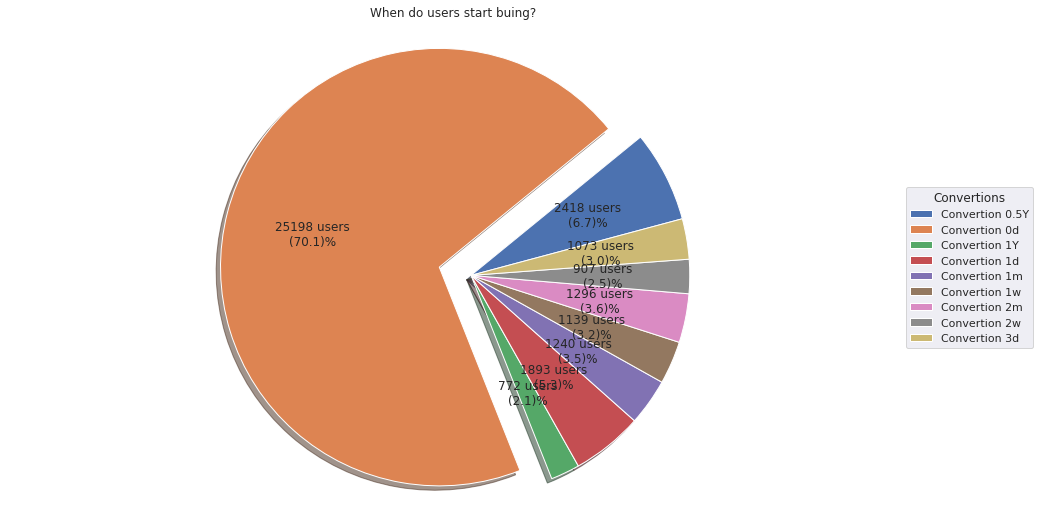

In [135]:
df = user_orders.groupby('convertion')[['uid']].nunique().reset_index()

fig, ax = plt.subplots(figsize = (16,9))
my_explode = (0, 0.15, 0, 0, 0, 0, 0, 0, 0)
plt.pie(df['uid'], autopct=lambda p:"{:.0f} users\n({:.1f})%".format(p*sum(df['uid'])/100, p), 
        startangle=15, shadow = True, explode=my_explode)
plt.title('When do users start buing?')
plt.axis('equal')
ax.legend(df['convertion'],
          title="Convertions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Most of users that start buying usually make their first purchase on the day they register. Almost 70 percent of buyers act this way, so we should focus on getting our user to final step during his first day, becuase later it becomes less likely that he would buy. 

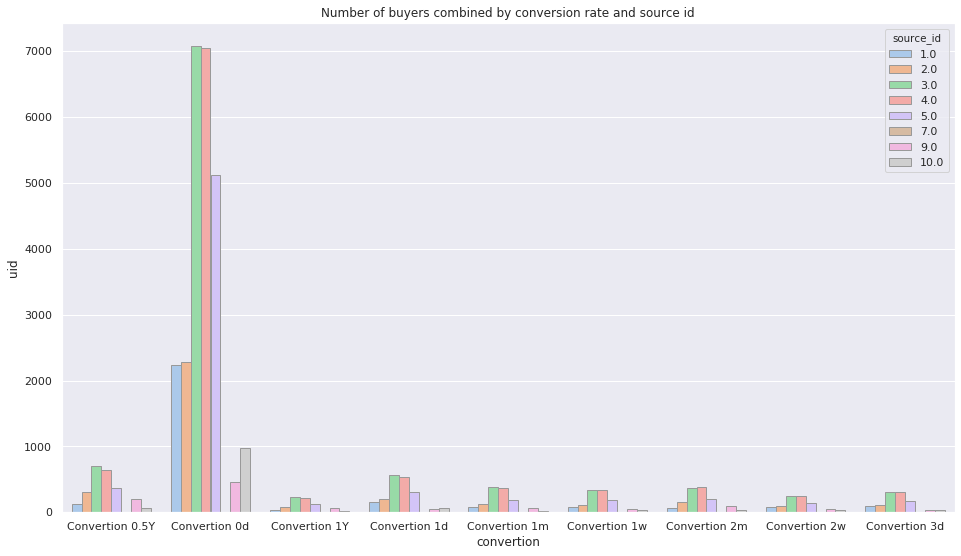

In [136]:
df = user_orders.groupby(['convertion','source_id'])[['uid']].nunique().reset_index()
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title('Number of buyers combined by conversion rate and source id')
plt.grid()
sns.barplot(x='convertion', y='uid', hue='source_id', data=df, palette="pastel", edgecolor=".6", ax=ax)

From here we can see that even though the scale is different, most effective ways to attract custumers stay the same. Most users who make purchase come from sources 3 and 4, while sources 10 and 7 show to be the most ineffective.

#### How many orders do they make during a given period of time?


For this I'll group all orders by the month they were made and will check how many orders were made each month.

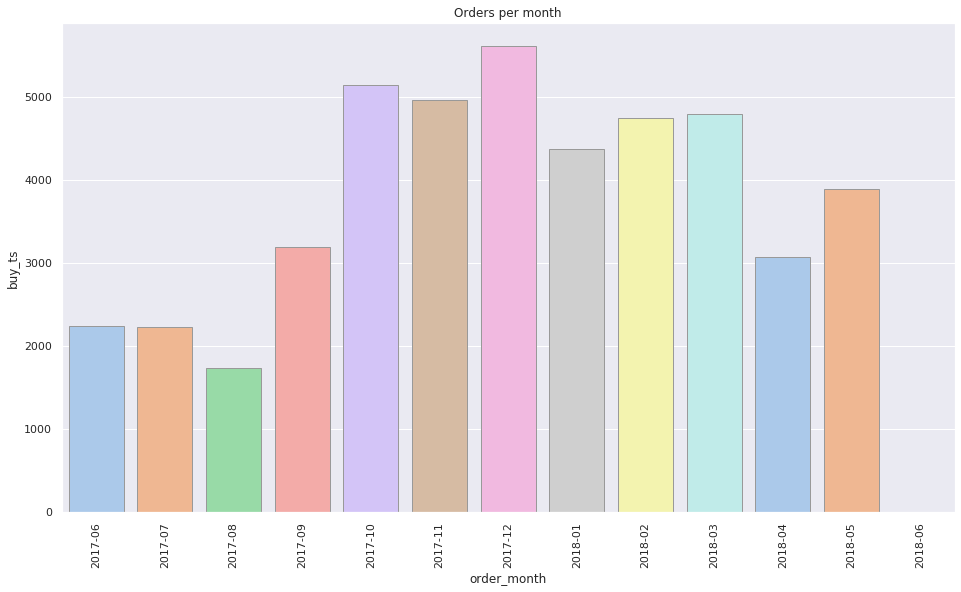

In [138]:
orders['order_month'] = orders.buy_ts.astype('datetime64[M]')
orders_per_month = orders.groupby('order_month')[['buy_ts','revenue']].agg({'buy_ts':'nunique', 'revenue':'sum'}).reset_index()
orders_per_month['order_month'] = orders_per_month['order_month'].dt.strftime('%Y-%m')
fig, ax = plt.subplots(figsize=(16, 9))
plt.xticks(rotation=90)
ax.set_title('Orders per month')
ax.set(xlabel='Order Month', ylabel='Orders Per Month')
plt.grid()
sns.barplot(x='order_month', y='buy_ts', data=orders_per_month, palette="pastel", edgecolor=".6", ax=ax)

Here I see that Yandex.Afisha definetly shows some success this year, bacause amount of orders have increased. I can't tell if we can expect same rise closer to the end of 2018, but the info is good.

Now let's check how many orders does a user make on average per month and what is average revenue per user per month.

In [140]:
orders_per_user_per_month = (
    orders
    .groupby(['order_month','uid'])[['buy_ts', 'revenue']]
    .agg({'buy_ts':'nunique', 'revenue':'sum'})
    .reset_index()
)

In [144]:
orders_per_user_per_month = (orders_per_user_per_month
                             .groupby('order_month')[['buy_ts','revenue']].mean().round(2)
                             .reset_index()
                            )
orders_per_user_per_month['order_month'] = orders_per_user_per_month['order_month'].dt.strftime('%Y-%m')
orders_per_user_per_month

,order_month,buy_ts,revenue
0,2017-06,1.16,4.72
1,2017-07,1.19,6.32
2,2017-08,1.23,5.95
3,2017-09,1.23,6.67
4,2017-10,1.21,5.99
5,2017-11,1.24,5.95
6,2017-12,1.26,7.36
7,2018-01,1.21,4.98
8,2018-02,1.24,6.00
9,2018-03,1.27,6.90


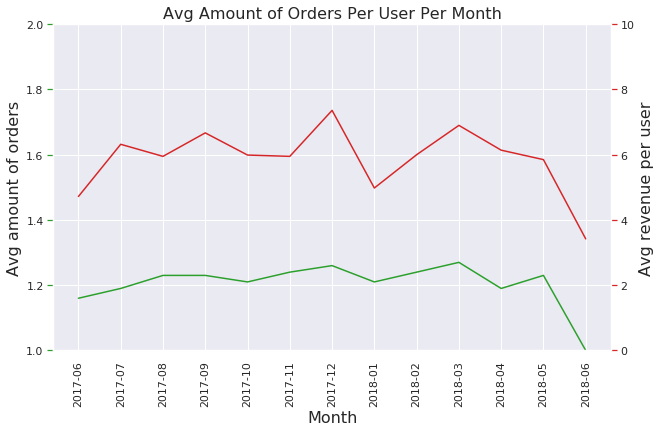

In [145]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Avg Amount of Orders Per User Per Month',fontsize=16)
plt.xticks(rotation=90)
ax.tick_params(axis='y')
plt.grid()
#plot line chart for amount of orders per month
plt.ylim(1,2)
sns.lineplot(x='order_month', y='buy_ts', data=orders_per_user_per_month, sort=False, ax=ax, color = 'tab:green')
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Avg amount of orders',fontsize=16)
ax.tick_params(axis='y', color='tab:green')
#plot line chart for revenue per user per month
ax2 = ax.twinx()
plt.ylim(0,10)
sns.lineplot(x='order_month', y='revenue', data=orders_per_user_per_month, sort=False, ax=ax2, color = 'tab:red')
ax2.set_ylabel('Avg revenue per user', fontsize=16)
ax2.tick_params(axis='y', color='tab:red')

#### Conclution
Here I see that on average people make around 1.2 orders per month and it doesn't really change that much throughout the time. So we can suppose that making a user do more orders per month might be a tough task, maybe because there is a limited amount of events that he wants to visit in one month. So I thing for us it's useful to keep the users that we have on the folowing months.

#### What is the average purchase size?

I have already calculated average profit per user per month in previous section.

In [146]:
print ('Average purchase size for one user per month: {:.2f}'.format(orders_per_user_per_month.revenue.mean()))

Average purchase size for one user per month: 5.87


But I can also calulate the average purchase per month instead, and see how it has changed.

In [147]:
orders.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [148]:
orders.pivot_table(index='buy_ts', columns='order_month', values='revenue')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
buy_ts,,,,,,,,,,,,,
2017-06-01 00:10:00,17.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-01 00:25:00,0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-01 00:27:00,0.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-01 00:29:00,0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-01 07:58:00,0.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-31 23:43:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.67,NaN
2018-05-31 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.22,NaN
2018-05-31 23:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30,NaN


In [149]:
(orders
 .groupby('order_month')[['buy_ts','revenue']]
 .agg({'buy_ts': 'nunique', 'revenue':'sum'})
)

,buy_ts,revenue
order_month,,
2017-06-01,2245,9557.49
2017-07-01,2236,12539.47
2017-08-01,1737,8758.78
2017-09-01,3188,18345.51
2017-10-01,5136,27987.70
2017-11-01,4964,27069.93
2017-12-01,5604,36388.60
2018-01-01,4369,19417.13
2018-02-01,4746,25560.54


In [150]:
revenue_per_month = (
    orders
    .groupby('order_month')[['buy_ts','revenue']]
    .agg({'buy_ts': 'nunique', 'revenue':'sum'})
    .eval('avg_purchase = revenue / buy_ts')
    .reset_index()
)

In [152]:
revenue_per_month

,order_month,buy_ts,revenue,avg_purchase
0,2017-06-01,2245,9557.49,4.257234
1,2017-07-01,2236,12539.47,5.607992
2,2017-08-01,1737,8758.78,5.042476
3,2017-09-01,3188,18345.51,5.754551
4,2017-10-01,5136,27987.70,5.449319
5,2017-11-01,4964,27069.93,5.453249
6,2017-12-01,5604,36388.60,6.493326
7,2018-01-01,4369,19417.13,4.444296
8,2018-02-01,4746,25560.54,5.385702
9,2018-03-01,4795,28834.59,6.013470


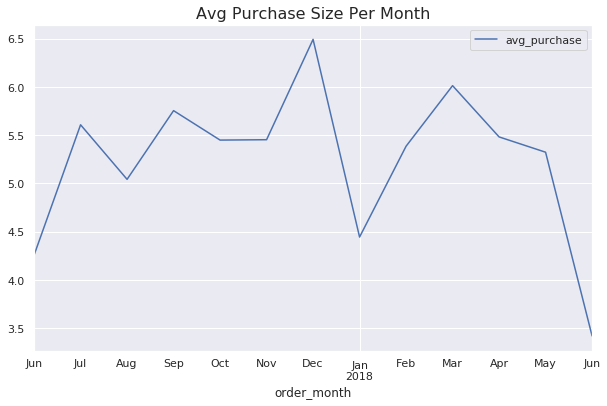

In [153]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Avg Purchase Size Per Month',fontsize=16)
plt.grid()
revenue_per_month.plot(y='avg_purchase', x='order_month', ax=ax, grid=True)


In [154]:
print ('Average purchase size: {:.2f}'.format(revenue_per_month.avg_purchase.mean()))

Average purchase size: 5.24


#### Conclusion

Average purchase fluctuated thorugh the year, we see that purchases sizes gut bigger by December and are very low for January. I suppose that in December lots of people buy tickets to children events and for company events for New Year, so maybe they buy in group, an that increases the average purchase size. In January there is a decrease in average purchase size which may be caused by the fact that there usually aren't any big events or concerts in the January, but I'm not certain about that:) 

#### How much money do they bring? (LTV)


For this I'm going to use monthly cohorts like I did before with visits when I was calculating retention pivot.

In [155]:
#get for each user his first order month
orders['first_order_month'] = orders.groupby('uid')['buy_ts'].transform('min').astype('datetime64[M]')
orders

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-01


Create dataframe for cohorts.

In [156]:
#create dataframe with amount of buyers for each month
cohort_sizes = (orders.groupby('first_order_month')
                .agg({'uid': 'nunique'})
                .reset_index()
                .rename(columns = {'uid': 'n_buyers'}, inplace = False)
               )
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [157]:
cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

In [158]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [159]:
report

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


Next step is to calculate LTV. We know that LTV is calculated based on gross profit, rather than on revenue, I need to find the gross profit by multiplying revenue by profitability. Second, LTV is a relative parameter, and it's easier to study for "mature" cohorts, so I'll make the columns show the cohort's age instead of the month of the order.

I don't have enough information to calculate margin rate by myself, but I'll use the value of 40% as an average for this calculation.

In [160]:
margin_rate = .4
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

#calculate LTV
report['ltv'] = report['gp'] / report['n_buyers']
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y-%m')
report.head()

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06,2023,2017-06-01,9557.49,3822.996,0,1.889766
1,2017-06,2023,2017-07-01,981.82,392.728,1,0.194131
2,2017-06,2023,2017-08-01,885.34,354.136,2,0.175055
3,2017-06,2023,2017-09-01,1931.30,772.520,3,0.381869
4,2017-06,2023,2017-10-01,2068.58,827.432,4,0.409012


In [161]:
output = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean').round(3)

output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,1.890,0.194,0.175,0.382,0.409,0.294,0.380,0.233,0.221,0.242,0.229,0.103
2017-07,2.404,0.134,0.249,0.144,0.071,0.062,0.048,0.057,0.064,0.059,0.062,NaN
2017-08,2.111,0.189,0.183,0.157,0.198,0.113,0.084,0.162,0.117,0.075,NaN,NaN
2017-09,2.258,0.447,0.208,1.590,0.160,0.259,0.281,0.097,0.074,NaN,NaN,NaN
2017-10,2.001,0.214,0.077,0.063,0.061,0.048,0.034,0.046,NaN,NaN,NaN,NaN
2017-11,2.062,0.160,0.080,0.130,0.059,0.022,0.046,NaN,NaN,NaN,NaN,NaN
2017-12,1.895,0.104,0.370,0.426,0.125,0.135,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.654,0.118,0.122,0.057,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.663,0.111,0.031,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


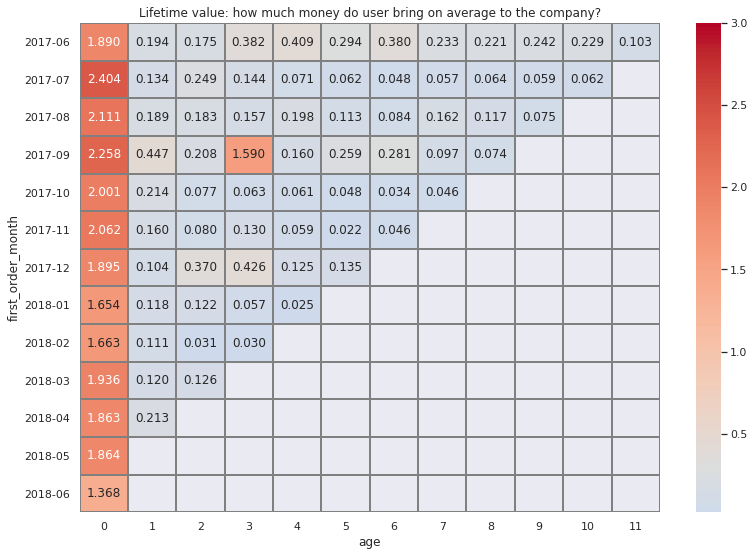

In [162]:
plt.figure(figsize=(13, 9))
plt.title('Lifetime value: how much money do user bring on average to the company?')
sns.heatmap(output, annot=True, fmt='.3f',cmap='coolwarm', linewidths=1, linecolor='gray',
            center=0.3, vmax=3);

#### Conclusion
1. On average one user doesn't bring a lot of money to Yandex.Afisha;
2. On average users bring most of the money during their first month;
3. There is one cohort that shows that on 4th month users have brought a comparable amount of money to their first month (I mean cohort of 2017-09);
4. Even when after a year users continue to come back to use the service, so we chouldn't disregard users from old cohorts.

### Marketing
#### How much money was spent? Overall/per source/over time


In [163]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [164]:
print ('Money spent overall: ', costs.costs.sum())

Money spent overall:  329131.62


Now let's check how the much money were spend over time

In [165]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [166]:
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [167]:
#group the data by week
costs['week_spending'] = costs.dt.astype('datetime64[W]')
costs['week_spending'] = costs['week_spending'].dt.strftime('%y-%m-%d')
costs_by_week = costs.groupby('week_spending')[['costs']].sum().reset_index()
costs_by_week.head()

,week_spending,costs
0,17-06-01,4750.61
1,17-06-08,4427.52
2,17-06-15,3933.09
3,17-06-22,3753.14
4,17-06-29,3743.03


Text(0, 0.5, 'Total spending per week')

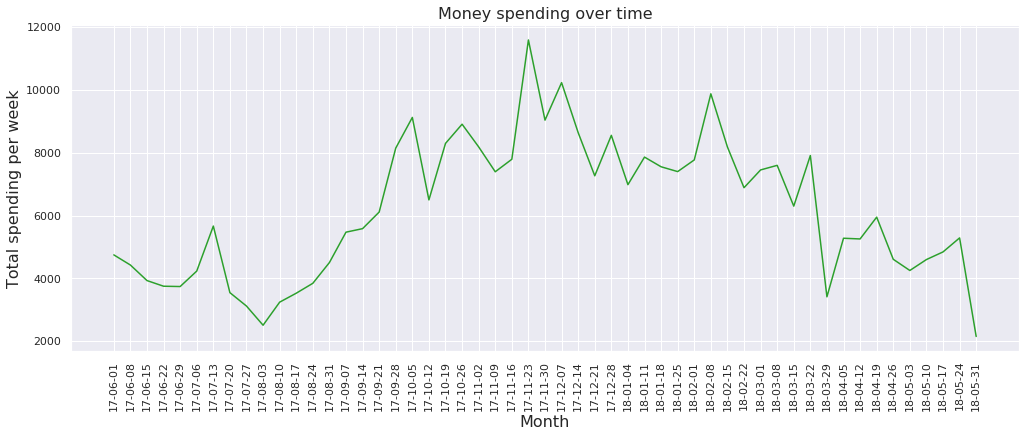

In [168]:
fig, ax = plt.subplots(figsize=(17, 6))
ax.set_title('Money spending over time',fontsize=16)
plt.xticks(rotation=90)
ax.tick_params(axis='y')
plt.grid()
#plot line chart for amount of orders per month
sns.lineplot(x='week_spending', y='costs', data=costs_by_week, sort=False, ax=ax, color = 'tab:green')
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Total spending per week',fontsize=16)

Here I see that amount of money spent on marketing has really fluctuated over time. Yandex.Afisha might be getting this decline of orders in recent months because money spending has fallen to much lower level. To make more further conclusions we'll need to see the data of previous years.

Now let's see what happened with spendings per source. First I'll check how spendings were generally distributed over sources.

In [169]:
costs_per_source = costs.groupby('source_id')[['costs']].sum().reset_index()
costs_per_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


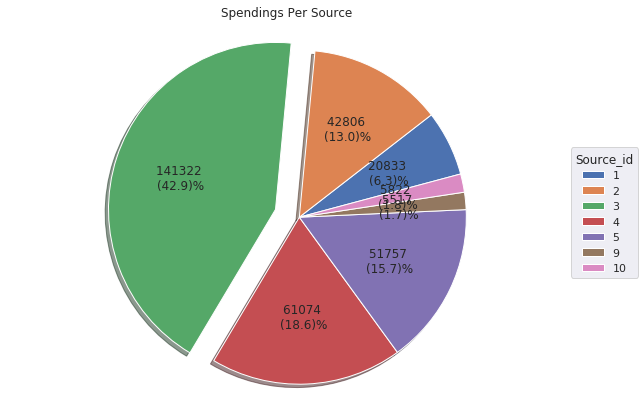

In [170]:
fig, ax = plt.subplots(figsize = (10,7))
my_explode = (0, 0, 0.15, 0, 0, 0, 0)
plt.pie(costs_per_source['costs'], autopct=lambda p:"{:.0f} \n({:.1f})%".format(p*sum(costs_per_source['costs'])/100, p), 
        startangle=15, shadow = True, explode=my_explode)
plt.title('Spendings Per Source')
plt.axis('equal')
ax.legend(costs_per_source['source_id'],
          title="Source_id",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Here I see that there are some sources that the source with most funding is source 3, while there are sources that get much less funding. 

Now let's check how distribution of average money spending per source has changed over time.

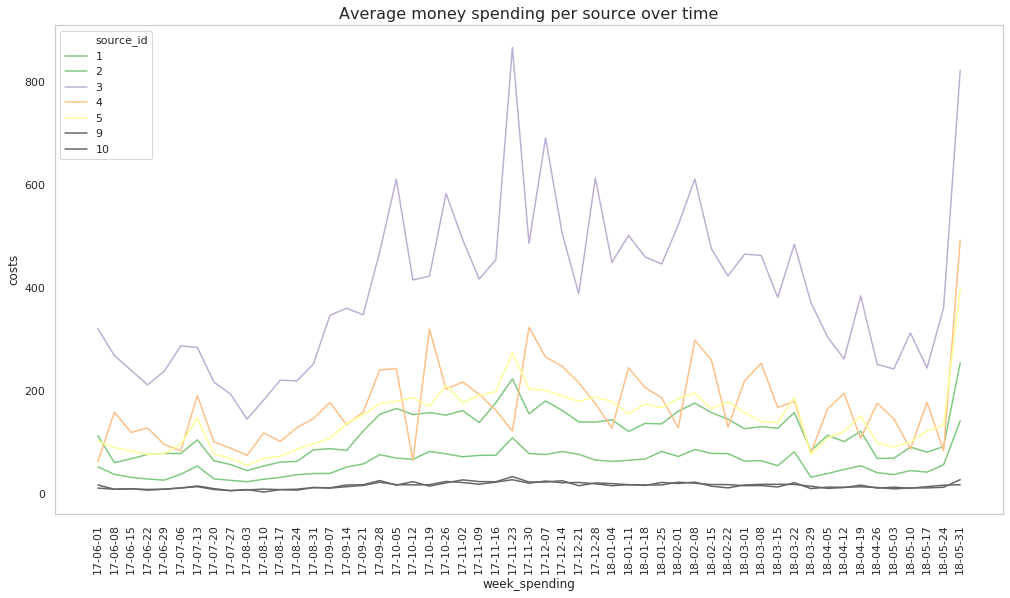

In [171]:
df = costs.groupby(['week_spending','source_id'])[['costs']].mean().reset_index()

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(17, 9))
ax.set_title('Average money spending per source over time', fontsize=16)
plt.xticks(rotation=90)
plt.grid()
sns.lineplot(x="week_spending", y="costs", hue='source_id',estimator=None, palette='Accent', legend="full", data=df);

Looks like it mostly stayed the same. So now let's combine this with data on how many users came to Yandex.Afisha from different sources to see if spending makes sence. This info is already stored in visits table.

In [172]:
source_visits = visits.groupby('source_id')[['uid']].nunique().reset_index()

In [173]:
#now let's convert both tables to percentages and merge them
source_visits['perc_of_users'] = (source_visits['uid'] / source_visits.uid.sum() *100).round(2)
costs_per_source['perc_of_money_spent'] = (costs_per_source['costs'] / costs_per_source['costs'].sum() *100).round(2)

In [174]:
source_visits[['source_id','perc_of_users']].merge(costs_per_source[['source_id','perc_of_money_spent']],
                                                   on='source_id', how='outer')

,source_id,perc_of_users,perc_of_money_spent
0,1,7.15,6.33
1,2,9.62,13.01
2,3,26.79,42.94
3,4,29.89,18.56
4,5,20.28,15.73
5,6,0.00,NaN
6,7,0.01,NaN
7,9,3.39,1.68
8,10,2.87,1.77


#### Conclusion

So from here it's obvious that there is some misdistribution of money. For example we spend 43 percent of spending on source 3 and 18,5 on source 4, while source 4 brings to Yandex.Afisha more users. That means that we spend on marketing of source 3 twice as much as on source 4, but we don't even get the same amount of users from that source. I suggest thta it would be good to refocus our more of our spendings to source 4 from source 3. Also we could add some more money to marketing source 5, it also brings to Yandex.Afisha many users, maybe this is worth looking into.

#### How much did customer acquisition from each of the sources cost?


In [176]:
users_per_source = visits.groupby('source_id')[['uid']].nunique().reset_index()

In [177]:
costs_per_source

,source_id,costs,perc_of_money_spent
0,1,20833.27,6.33
1,2,42806.04,13.01
2,3,141321.63,42.94
3,4,61073.60,18.56
4,5,51757.10,15.73
5,9,5517.49,1.68
6,10,5822.49,1.77


In [178]:
users_per_source = users_per_source.merge(costs_per_source[['source_id','costs']],
                                                   on='source_id', how='outer')


In [179]:
users_per_source['cost_per_user'] = (users_per_source.costs / users_per_source.uid)
users_per_source = users_per_source.sort_values('cost_per_user', ascending = False)
users_per_source

,source_id,uid,costs,cost_per_user
2,3,67284,141321.63,2.100375
1,2,24152,42806.04,1.772360
0,1,17960,20833.27,1.159982
4,5,50921,51757.10,1.016420
3,4,75080,61073.60,0.813447
8,10,7208,5822.49,0.807782
7,9,8504,5517.49,0.648811
5,6,5,NaN,NaN
6,7,33,NaN,NaN


#### Conclusion

So here I see that the most expencive users to aquire come from source 3. While getting a user from source 4 (that brings almost the same amount of users) is more than 2 times less. So I keep my suggestions of rederecting more money spendings to source 4 because it brings the highest amount of users at very low cost.

#### How worthwhile where the investments? (ROI)

For this I will use data that I have created before for calculating LTV - <i>report</i> table.

In [181]:
report

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06,2023,2017-06-01,9557.49,3822.996,0,1.889766
1,2017-06,2023,2017-07-01,981.82,392.728,1,0.194131
2,2017-06,2023,2017-08-01,885.34,354.136,2,0.175055
3,2017-06,2023,2017-09-01,1931.30,772.520,3,0.381869
4,2017-06,2023,2017-10-01,2068.58,827.432,4,0.409012
...,...,...,...,...,...,...,...
74,2018-03,3533,2018-05-01,1114.87,445.948,2,0.126224
75,2018-04,2276,2018-04-01,10600.69,4240.276,0,1.863039
76,2018-04,2276,2018-05-01,1209.92,483.968,1,0.212640
77,2018-05,2988,2018-05-01,13925.76,5570.304,0,1.864225


In [182]:
#get first_order_month column back to normal
report['first_order_month'] = pd.to_datetime(report['first_order_month'])

In [183]:
#calculate cost per month
costs

,source_id,dt,costs,week_spending
0,1,2017-06-01,75.20,17-06-01
1,1,2017-06-02,62.25,17-06-01
2,1,2017-06-03,36.53,17-06-01
3,1,2017-06-04,55.00,17-06-01
4,1,2017-06-05,57.08,17-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,18-05-24
2538,10,2018-05-28,21.26,18-05-24
2539,10,2018-05-29,11.32,18-05-24
2540,10,2018-05-30,33.15,18-05-24


In [184]:
costs['month'] = costs.dt.astype('datetime64[M]')
monthly_costs = costs.groupby('month').sum()

In [185]:
report_ = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_['cac'] = report_['costs'] / report_['n_buyers']
report_.head()

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,source_id,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,3822.996,0,1.889766,1020,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,392.728,1,0.194131,1020,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,354.136,2,0.175055,1020,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,772.520,3,0.381869,1020,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,827.432,4,0.409012,1020,18015.0,8.905091


In [186]:
#Calculate ROI
report_['roi'] = report_['ltv'] / report_['cac']
output = report_.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='roi', 
    aggfunc='mean')

output.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.21,0.23,0.25,0.30,0.34,0.38,0.42,0.44,0.47,0.50,0.52,0.53
2017-07-01,0.25,0.27,0.29,0.31,0.32,0.32,0.33,0.33,0.34,0.35,0.35,NaN
2017-08-01,0.20,0.21,0.23,0.24,0.26,0.27,0.28,0.30,0.31,0.31,NaN,NaN
2017-09-01,0.24,0.29,0.31,0.48,0.49,0.52,0.55,0.56,0.57,NaN,NaN,NaN
2017-10-01,0.24,0.26,0.27,0.28,0.29,0.29,0.30,0.30,NaN,NaN,NaN,NaN
2017-11-01,0.22,0.24,0.25,0.26,0.27,0.27,0.28,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.22,0.23,0.27,0.32,0.33,0.35,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.17,0.18,0.19,0.20,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.19,0.20,0.20,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here I see that none of the cohorts has actually showed any retern of marketing invesments. Cohort of 09.2017 shows to be the most profitable yet. Last cohorts don't chow any return of investments  after their first month, seems like they don't come back at all. We should expect that we get some return of investments if user will continue using Yandex.Afisha after at least 2 years of usage, that seems to be really too long.

## Step 3. Write a conclusion: advise marketing experts how much money to invest and where.

Based on performed analysis I can see that Yandex.Afisha doesn't bring lots of money in, while spendings are way up high. There are few things that I can recomend here to make investments worthwhile:
1. Most of users come from add sources 3 and 4, they bring simillar amount of users, but source 4 is almost twice cheaper and more effective. Therefore I recomend to focus spendings on source 4 and cut some money on marketing through source 3. It may also be usefull to try to redirect some money to source 5, because it's also showing to be really effective;
2. It takes really long time to get return of investments, average user can get ROI at around 0.5 only after a year, here I recomend to try to focus more on keeping existing custumers with notificatins and e-mails;
3. Most people spend most of their money during their first month, especially during first days after their first visit, so it's important to keep people there;
3. Check what has happened to website/app in last months, maybe there've been some design changes that made people less interested in the platform;
4. New users bring more money than old ones, it's important to focus on new users, because they bring really high percent of their money in the first month (actually more like first purchase).